Importando as bibliotecas principais:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv1D, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MSE
import tensorflow as tf

Instalando o gdown para baixar arquivos do Google Drive (neste caso, vamos fazer o download do arquivo csv):

In [ ]:
!pip install gdown

In [ ]:
import gdown

Download do arquivo:

In [ ]:
url = "https://drive.google.com/u/1/uc?id=1F8jSkzJ4raeCzcqptyC1C51QdmmAEY4Q&export=download"
output = 'df_total.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/1/uc?id=1F8jSkzJ4raeCzcqptyC1C51QdmmAEY4Q&export=download
To: /content/df_total.csv
100%|██████████| 25.2M/25.2M [00:00<00:00, 44.3MB/s]


'df_total.csv'

Mostrando as primeiras linhas do dataset:

In [ ]:
df = pd.read_csv('df_total.csv')
df.head()

,device_name,mean_n_bytes,stdev_n_bytes,median_n_bytes,mean_timestamp,stdev_timestamp,median_timestamp
0,Assistant1,121.666667,57.185857,157.0,1.474553e+09,6.363523,1.474553e+09
1,Assistant1,126.666667,50.135372,157.0,1.474553e+09,4.934770,1.474553e+09
2,Assistant1,121.666667,57.185857,157.0,1.474553e+09,5.098356,1.474553e+09
3,Assistant1,51.000000,7.071068,56.0,1.474553e+09,4.278881,1.474553e+09
4,Assistant1,121.666667,57.185857,157.0,1.474553e+09,10.553324,1.474553e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271931 entries, 0 to 271930
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_name       271931 non-null  object 
 1   mean_n_bytes      271931 non-null  float64
 2   stdev_n_bytes     271931 non-null  float64
 3   median_n_bytes    271931 non-null  float64
 4   mean_timestamp    271931 non-null  float64
 5   stdev_timestamp   271931 non-null  float64
 6   median_timestamp  271931 non-null  float64
dtypes: float64(6), object(1)
memory usage: 14.5+ MB


Removendo as colunas de endereço MAC, pois não são interessantes para o treinamento do modelo.

In [ ]:
#df = df.drop('mac_src', axis=1)
#df = df.drop('mac_dst', axis=1)
#df.head()

Calculando medidas estatísticas para as colunas de "timestamp" e "len", de forma a termos mais características no dataset. Features como endereço MAC, IP e porta são consideradas invasivas, podendo ocasionar em invasão de privacidade. Timestamp e tamanho do pacote são features passivas e se encaixam melhor neste processo.

In [ ]:
def statistical_features_by_day_perPacket(df_total):

	"""
	Manipulacao dos dados para extracao de medidas estatisticas no nivel de pacote
	Organizacao de saidas para os plots dos graficos
	Para cada grupo de device extrai um subgrupo
	"""
	#print(df_total.columns)
	devicegroup = df_total.groupby(['device_src_name'])

	all_devices_samples = []
	for name, amostra in tqdm(devicegroup, unit = "device"): # tqdm = progress bar
		if (len(amostra.index) > 2):

			# use for plots
			#SAMPLERANGE = len(amostra)
			#amostras_tamanho_x = np.array_split(amostra, len(amostra)/SAMPLERANGE)
			# use for ML algorithms
			amostras_tamanho_x = np.array_split(amostra, len(amostra)/3)

			for device in amostras_tamanho_x:
				#print(device)

				device = pd.DataFrame(device)

				all_devices_samples.append(
					pd.DataFrame(data={
					# ['ip_src', 'ip_dst', 'proto', 'timestamp', 'mac_src', 'mac_dst', 'len', 'src_port', 'dst_port', 'device']

					"device_name": [str(device["device_src_name"].values[0])],
					#"n_packets":  [device['device_src_name'].count()],
					"mean_n_bytes": [device['len'].mean()],
					"stdev_n_bytes": [device['len'].std(ddof=0)],
					#"min_n_bytes": [device['len'].min()],
					#"max_n_bytes": [device['len'].max()],
					#"sum_n_bytes": [device['len'].sum()],
					"median_n_bytes": [device['len'].median()],
					"mean_timestamp": [device['timestamp'].mean()],
					"stdev_timestamp": [device['timestamp'].std(ddof=0)],
					#"sum_timestamp": [device['timestamp'].sum()],
					"median_timestamp": [device['timestamp'].median()],
					#"min_timestamp": [device['timestamp'].min()],
					#"max_timestamp": [device['timestamp'].max()],
          }))

	all_devices_samples = pd.concat(all_devices_samples)

	## salva o df aqui #####
	#all_devices_samples.to_csv(PACKETPLOTSDIR + (file.split('/')[-1]), index=False)
	#print('done writing statistical features to : ' + PACKETPLOTSDIR + (file.split('/')[-1]))

	return all_devices_samples

In [ ]:
#df = statistical_features_by_day_perPacket(df)
#df.head()

In [ ]:
#df.to_csv('df_statistic.csv', index=False)

Transformando os valores da coluna device_src_name em inteiros:

In [ ]:
le = LabelEncoder()

df['device_name'] = le.fit_transform(df['device_name'].values)

df

,device_name,mean_n_bytes,stdev_n_bytes,median_n_bytes,mean_timestamp,stdev_timestamp,median_timestamp
0,0,121.666667,57.185857,157.0,1.474553e+09,6.363523,1.474553e+09
1,0,126.666667,50.135372,157.0,1.474553e+09,4.934770,1.474553e+09
2,0,121.666667,57.185857,157.0,1.474553e+09,5.098356,1.474553e+09
3,0,51.000000,7.071068,56.0,1.474553e+09,4.278881,1.474553e+09
4,0,121.666667,57.185857,157.0,1.474553e+09,10.553324,1.474553e+09
...,...,...,...,...,...,...,...
271926,21,723.000000,519.178197,461.0,1.474726e+09,0.018630,1.474726e+09
271927,21,741.666667,502.948860,461.0,1.474726e+09,0.005328,1.474726e+09
271928,21,674.666667,547.306942,316.0,1.474726e+09,0.074030,1.474726e+09
271929,21,723.000000,519.178197,461.0,1.474726e+09,0.019869,1.474726e+09


Separando a coluna que vamos classificar em um dataset isolado, contendo apenas esta coluna:

In [ ]:
df_x = df.drop('device_name', axis=1)
df_y = df['device_name']

df_y

0          0
1          0
2          0
3          0
4          0
          ..
271926    21
271927    21
271928    21
271929    21
271930    21
Name: device_name, Length: 271931, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, random_state=42, test_size=0.3)
print('Número de casos de treino: ', X_train.shape[0])
print('Número de casos de teste: ', X_test.shape[0])

Número de casos de treino:  190351
Número de casos de teste:  81580


Usando classificador Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier().fit(X_train, y_train)

dt_predictions = dt_model.predict(X_test)
print('Acurácia do modelo: ', accuracy_score(y_test, dt_predictions))

Acurácia do modelo:  0.9717822995832311


In [ ]:
print('Classification Report'.center(70, '='))
print(classification_report(y_test, dt_predictions))

print('Matriz de confusão'.center(70, '='))
print(confusion_matrix(y_test, dt_predictions))

========================Classification Report=========================
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3104
           1       0.93      0.90      0.91       198
           2       0.00      0.00      0.00         1
           3       0.97      0.97      0.97      1807
           4       0.97      0.98      0.97       570
           5       0.99      0.99      0.99      5593
           6       1.00      1.00      1.00     19281
           7       0.99      0.99      0.99      1945
           8       0.98      0.98      0.98     39453
           9       0.81      0.81      0.81      2698
          10       0.95      0.95      0.95      1462
          11       0.67      0.66      0.66       440
          12       0.12      0.16      0.13        19
          13       0.88      0.91      0.90       284
          14       0.87      0.86      0.87       320
          15       0.91      0.62      0.74        16
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Usando MLP:

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=0)

mlp.fit(X_train, y_train)
mlp_predictions = mlp.predict(X_test)

print('Acurácia: ', accuracy_score(y_test, mlp_predictions))

Acurácia:  0.4836111792105908


Usando Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, rf_pred)
print('Acurácia: ', accuracy)

Acurácia:  0.9794802647707771


Usando regressão logística (com parâmetros que permitem usar este modelo na versão multinomial/multiclasse):
A regressão logística não funciona muito bem com esse tipo de dados...

In [ ]:
#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

#lr.fit(X_train, y_train)
#lr_pred = lr.predict(X_test)

#accuracy = accuracy_score(y_test, lr_pred)
#print('Acurácia: ', accuracy)

Acurácia:  0.5512267870640871


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Usando K-Neighbors:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')

kn.fit(X_train, y_train)
kn_pred = kn.predict(X_test)

accuracy = accuracy_score(y_test, kn_pred)
print('Acurácia: ', accuracy)

Acurácia:  0.8079431233145379


Verificando os diferentes valores de K no K-Neighbors. De acordo com o gráfico, nos nossos dados, a acurácia do modelo tende a abaixar conforme o valor de K aumenta.

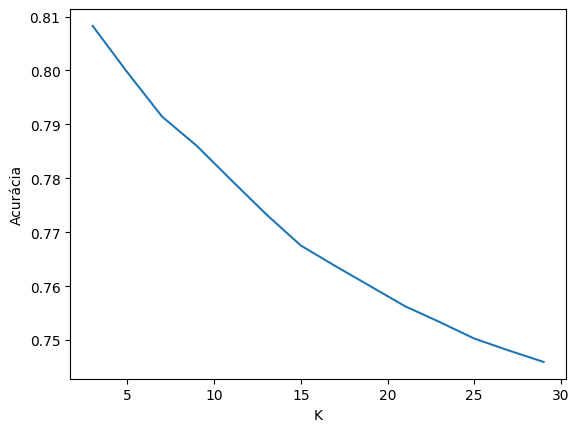

In [ ]:
acc = {}

for k in range(3, 30, 2):
  kn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  kn.fit(X_train, y_train)

  kn_pred = kn.predict(X_test)
  acc[k] = accuracy_score(y_test, kn_pred)

plt.plot(range(3, 30, 2), acc.values())
plt.xlabel('K')
plt.ylabel('Acurácia')
plt.show()

Usando o Perceptron:

In [ ]:
from sklearn.linear_model import Perceptron
p_model = Perceptron(max_iter=100, eta0=0.1, random_state=42)

p_model.fit(X_train, y_train)
p_pred = p_model.predict(X_test)

accuracy = accuracy_score(y_test, p_pred)
print('Acurácia: ', accuracy)

Acurácia:  0.4836111792105908


In [ ]:
# linha abaixo corrige o erro 'TensorFlow is executing eagerly. Please disable eager execution.' e 'maximum recursion depth exceeded'
tf.compat.v1.disable_eager_execution()

Testando redes neurais...

In [ ]:
model = Sequential()
# primeira camada, utilizando a função de ativação ReLU e 6 colunas (mesmo número de colunas do nosso dataframe X)
model.add(Dense(100, activation='relu', input_shape=(6,)))
# segunda camada, usando 22 pois o maior número na coluna Y (das labels) é 21. softmax é uma função de ativação para classificação multi-classe
model.add(Dense(22, activation='softmax'))

# compilando o modelo. primeiramente tentei usar categorical_crossentropy como a função de perda, mas apresentou erro. funcionou com a sparse
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

perda, acuracia = model.evaluate(X_test, y_test)

print(f"Perda no teste: {perda}, Acurácia no teste: {acuracia}")

Epoch 1/10
1339/1339 [==============================] - 10s 6ms/step - loss: 11726215.0000 - accuracy: 0.2972 - val_loss: 7819026.5000 - val_accuracy: 0.4856
Epoch 2/10
1339/1339 [==============================] - 6s 4ms/step - loss: 9477126.0000 - accuracy: 0.2982 - val_loss: 6162945.0000 - val_accuracy: 0.2333
Epoch 3/10
1339/1339 [==============================] - 9s 6ms/step - loss: 8304854.5000 - accuracy: 0.2993 - val_loss: 13744315.0000 - val_accuracy: 0.0392
Epoch 4/10
1339/1339 [==============================] - 6s 4ms/step - loss: 7214370.0000 - accuracy: 0.2981 - val_loss: 4170247.5000 - val_accuracy: 0.4856
Epoch 5/10
1339/1339 [==============================] - 6s 5ms/step - loss: 6144476.0000 - accuracy: 0.2991 - val_loss: 4537136.0000 - val_accuracy: 0.4856
Epoch 6/10
1339/1339 [==============================] - 3s 2ms/step - loss: 5444016.0000 - accuracy: 0.2975 - val_loss: 3772888.0000 - val_accuracy: 0.4856
Epoch 7/10
1339/1339 [==============================] - 5s 4m

Mais uma rede neural, testando outros tipos de camadas:

In [ ]:
model_2 = Sequential()
# camada de dropout é utilizada para reduzir overfitting
model_2.add(Dropout(0.2, input_shape=(6,)))
# camada densa possui uma matriz de pesos que é ajustada durante o processo de treinamento.
# função de ativação relu
model_2.add(Dense(100, activation='relu', input_shape=(6,)))

# outra camada densa, com o valor mínimo de 22, pois temos 21 classificações diferentes de device_name
model_2.add(Dense(22,))
# batchnormalization normaliza as entradas, mantendo a média da saída perto de 0 e o desvio padrão perto de 1. traz mais estabilidade
model_2.add(BatchNormalization())
# softmax usado como a última função de ativação da rede neural
model_2.add(Activation('softmax'))

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

perda, acuracia = model_2.evaluate(X_test, y_test)

print(f"Perda no teste: {perda}, Acurácia no teste: {acuracia}")

Instructions for updating:
Colocations handled automatically by placer.


Train on 171315 samples, validate on 19036 samples
Epoch 1/10
170752/171315 [============================>.] - ETA: 0s - loss: 2.4600 - accuracy: 0.3847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


171315/171315 [==============================] - 6s 34us/sample - loss: 2.4584 - accuracy: 0.3850 - val_loss: 2.0082 - val_accuracy: 0.4856
Epoch 2/10
171315/171315 [==============================] - 8s 44us/sample - loss: 1.8478 - accuracy: 0.4798 - val_loss: 1.7514 - val_accuracy: 0.4856
Epoch 3/10
171315/171315 [==============================] - 7s 41us/sample - loss: 1.7340 - accuracy: 0.4800 - val_loss: 1.7110 - val_accuracy: 0.4856
Epoch 4/10
171315/171315 [==============================] - 7s 43us/sample - loss: 1.7103 - accuracy: 0.4800 - val_loss: 1.6982 - val_accuracy: 0.4856
Epoch 5/10
171315/171315 [==============================] - 6s 37us/sample - loss: 1.7028 - accuracy: 0.4800 - val_loss: 1.6938 - val_accuracy: 0.4856
Epoch 6/10
171315/171315 [==============================] - 6s 32us/sample - loss: 1.6997 - accuracy: 0.4800 - val_loss: 1.6940 - val_accuracy: 0.4856
Epoch 7/10
171315/171315 [==============================] - 6s 36us/sample - loss: 1.6983 - accuracy: 0.4

Mesmas camadas mas com outros parâmetros?

In [ ]:
model_3 = Sequential()
model_3.add(Dropout(0.2, input_shape=(6,)))
model_3.add(Dense(100, activation='relu'))

model_3.add(Dense(22,))
model_3.add(BatchNormalization())
model_3.add(Activation('softmax'))

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.fit(X_train, y_train, batch_size=50, epochs=15, validation_split=0.1)

perda, acuracia = model_3.evaluate(X_test, y_test)

print(f"Perda no teste: {perda}, Acurácia no teste: {acuracia}")

Train on 171315 samples, validate on 19036 samples
Epoch 1/15
170650/171315 [============================>.] - ETA: 0s - loss: 2.0722 - accuracy: 0.4480

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


171315/171315 [==============================] - 15s 87us/sample - loss: 2.0705 - accuracy: 0.4484 - val_loss: 1.7242 - val_accuracy: 0.4856
Epoch 2/15
171315/171315 [==============================] - 6s 38us/sample - loss: 1.7104 - accuracy: 0.4800 - val_loss: 1.6940 - val_accuracy: 0.4856
Epoch 3/15
171315/171315 [==============================] - 7s 41us/sample - loss: 1.6990 - accuracy: 0.4800 - val_loss: 1.6909 - val_accuracy: 0.4856
Epoch 4/15
171315/171315 [==============================] - 6s 35us/sample - loss: 1.6974 - accuracy: 0.4800 - val_loss: 1.6902 - val_accuracy: 0.4856
Epoch 5/15
171315/171315 [==============================] - 8s 44us/sample - loss: 1.6971 - accuracy: 0.4800 - val_loss: 1.6903 - val_accuracy: 0.4856
Epoch 6/15
171315/171315 [==============================] - 6s 34us/sample - loss: 1.6970 - accuracy: 0.4800 - val_loss: 1.6900 - val_accuracy: 0.4856
Epoch 7/15
171315/171315 [==============================] - 7s 44us/sample - loss: 1.6970 - accuracy: 0.

Alterando os parâmetros novamente:

In [ ]:
model_4 = Sequential()
model_4.add(Dropout(0.5, input_shape=(6,)))
model_4.add(Dense(100, activation='relu', input_shape=(6,)))

model_4.add(Dense(22,))
model_4.add(BatchNormalization())
model_4.add(Activation('softmax'))

model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.5)

perda, acuracia = model_4.evaluate(X_test, y_test)

print(f"Perda no teste: {perda}, Acurácia no teste: {acuracia}")

Epoch 1/10
2975/2975 [==============================] - 15s 4ms/step - loss: 2.1250 - accuracy: 0.4520 - val_loss: 1.7467 - val_accuracy: 0.4807
Epoch 2/10
2975/2975 [==============================] - 12s 4ms/step - loss: 1.7180 - accuracy: 0.4805 - val_loss: 1.7032 - val_accuracy: 0.4807
Epoch 3/10
2967/2975 [============================>.] - ETA: 0s - loss: 1.7012 - accuracy: 0.4804

KeyboardInterrupt: 

Iniciando com modelos adversariais, utilizando o método FGSM:

In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
#pip install scikeras

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [ ]:
# https://embracethered.com/blog/posts/2020/husky-ai-adversarial-robustness-toolbox-testing/
# https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/1977
# https://stackoverflow.com/questions/53676883/dnnclassifier-dataframe-object-has-no-attribute-dtype

art_classifier = KerasClassifier(model=model_2, use_logits=False)  ## modelo é o modelo treinado que faz o model.fit()

attack = FastGradientMethod(estimator=art_classifier, eps=0.8) ## brincar com o eps
x_test_fgsm = attack.generate(x=X_test.values)
print(x_test_fgsm)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[ 8.1999998e+00 -8.0000001e-01  8.1999998e+00  1.4747069e+09
   1.7130913e+01  1.4747069e+09]
 [ 8.9199997e+01 -8.0000001e-01  8.9199997e+01  1.4747048e+09
   1.6468773e+00  1.4747048e+09]
 [ 1.4092000e+03 -8.0000001e-01  1.4092000e+03  1.4746001e+09
   8.0009556e-01  1.4746001e+09]
 ...
 [ 1.4472000e+03 -8.0000001e-01  1.4472000e+03  1.4745998e+09
   8.0018365e-01  1.4745998e+09]
 [ 3.3986667e+02  1.5382285e+02  4.4820001e+02  1.4747127e+09
   1.4066802e+01  1.4747127e+09]
 [ 1.0245333e+03  5.9694092e+02  1.4472000e+03  1.4745924e+09
   8.2479382e-01  1.4745924e+09]]


In [ ]:
x_test_fgsm.shape

(81580, 6)

In [ ]:
df_fgsm = pd.DataFrame(x_test_fgsm, columns=X_test.columns)
df_fgsm

,mean_n_bytes,stdev_n_bytes,median_n_bytes,mean_timestamp,stdev_timestamp,median_timestamp
0,8.200000,-0.800000,8.200000,1.474707e+09,17.130913,1.474707e+09
1,89.199997,-0.800000,89.199997,1.474705e+09,1.646877,1.474705e+09
2,1409.199951,-0.800000,1409.199951,1.474600e+09,0.800096,1.474600e+09
3,89.199997,-0.800000,89.199997,1.474720e+09,1.642676,1.474720e+09
4,1447.199951,-0.800000,1447.199951,1.474683e+09,0.800062,1.474683e+09
...,...,...,...,...,...,...
81575,0.200000,-0.800000,0.200000,1.474556e+09,9.119803,1.474556e+09
81576,89.199997,-0.800000,89.199997,1.474625e+09,1.641702,1.474625e+09
81577,1447.199951,-0.800000,1447.199951,1.474600e+09,0.800184,1.474600e+09
81578,339.866669,153.822845,448.200012,1.474713e+09,14.066802,1.474713e+09


In [ ]:
X_test

,mean_n_bytes,stdev_n_bytes,median_n_bytes,mean_timestamp,stdev_timestamp,median_timestamp
16823,9.000000,0.000000,9.0,1.474707e+09,16.330913,1.474707e+09
96248,90.000000,0.000000,90.0,1.474705e+09,0.846877,1.474705e+09
137356,1410.000000,0.000000,1410.0,1.474600e+09,0.000096,1.474600e+09
100914,90.000000,0.000000,90.0,1.474720e+09,0.842676,1.474720e+09
180693,1448.000000,0.000000,1448.0,1.474683e+09,0.000062,1.474683e+09
...,...,...,...,...,...,...
102569,1.000000,0.000000,1.0,1.474556e+09,8.319804,1.474556e+09
72377,90.000000,0.000000,90.0,1.474625e+09,0.841702,1.474625e+09
243226,1448.000000,0.000000,1448.0,1.474600e+09,0.000184,1.474600e+09
36575,340.666667,154.622839,449.0,1.474713e+09,13.266802,1.474713e+09


In [ ]:
pred_fgsm = np.argmax(model_2.predict(df_fgsm), axis=1)

print(pred_fgsm)

[8 8 8 ... 8 8 8]


In [ ]:
df_test = pd.DataFrame(pred_fgsm)
print(df_test[0].value_counts())

0
8    81580
Name: count, dtype: int64


In [ ]:
# https://stackoverflow.com/questions/71874695/valueerror-classification-metrics-cant-handle-a-mix-of-multiclass-and-continuo
acuracia_fgsm = accuracy_score(y_test, pred_fgsm)
print('Acuracia: ', acuracia_fgsm)

Acuracia:  0.4836111792105908


Aplicando o FGSM no nosso modelo linear de árvore de decisão implementado anteriormente, para verificar o funcionamento do ataque adversarial. Podemos verificar que a acurácia reduziu de 97% para 73%:

In [ ]:
#art_classifier_dt = KerasClassifier(model=model_2, use_logits=False)  ## modelo é o modelo treinado que faz o model.fit()

#attack = FastGradientMethod(estimator=art_classifier_dt, eps=0.8) ## brincar com o eps
dt_x_test_fgsm = attack.generate(x=X_test.values)

dt_df_fgsm = pd.DataFrame(dt_x_test_fgsm, columns=X_test.columns)

pred_dt_fgsm = dt_model.predict(dt_df_fgsm)

dt_acuracia_fgsm = accuracy_score(y_test, pred_dt_fgsm)
print('Acuracia :', dt_acuracia_fgsm)

Acuracia : 0.7396175533218926


In [ ]:
rf_x_test_fgsm = attack.generate(x=X_test.values)

rf_df_fgsm = pd.DataFrame(rf_x_test_fgsm, columns=X_test.columns)

pred_rf_fgsm = rf.predict(rf_df_fgsm)

rf_acuracia_fgsm = accuracy_score(y_test, pred_rf_fgsm)
print('Acuracia :', rf_acuracia_fgsm)

Acuracia : 0.867210100514832


In [ ]:
kn_x_test_fgsm = attack.generate(x=X_test.values)

kn_df_fgsm = pd.DataFrame(kn_x_test_fgsm, columns=X_test.columns)

pred_kn_fgsm = kn.predict(kn_df_fgsm)

kn_acuracia_fgsm = accuracy_score(y_test, pred_kn_fgsm)
print('Acuracia :', kn_acuracia_fgsm)

Acuracia : 0.7853885756312822


In [ ]:
from art.attacks.evasion import DeepFool

In [ ]:
frame_art_classifier = KerasClassifier(model=model_2, use_logits=False)  ## modelo é o modelo treinado que faz o model.fit()

frame_attack = DeepFool(classifier=frame_art_classifier, batch_size=128) ## brincar com o eps
frame_x_test_fgsm = frame_attack.generate(x=X_test.values)

frame_df_fgsm = pd.DataFrame(frame_x_test_fgsm, columns=X_test.columns)
frame_df_fgsm

DeepFool:   0%|          | 0/638 [00:00<?, ?it/s]

,mean_n_bytes,stdev_n_bytes,median_n_bytes,mean_timestamp,stdev_timestamp,median_timestamp
0,9.000000,0.000000,9.0,1.474707e+09,16.330914,1.474707e+09
1,90.000000,0.000000,90.0,1.474705e+09,0.846877,1.474705e+09
2,1410.000000,0.000000,1410.0,1.474600e+09,0.000096,1.474600e+09
3,90.000000,0.000000,90.0,1.474720e+09,0.842676,1.474720e+09
4,1448.000000,0.000000,1448.0,1.474683e+09,0.000062,1.474683e+09
...,...,...,...,...,...,...
81575,1.000000,0.000000,1.0,1.474556e+09,8.319804,1.474556e+09
81576,90.000000,0.000000,90.0,1.474625e+09,0.841702,1.474625e+09
81577,1448.000000,0.000000,1448.0,1.474600e+09,0.000184,1.474600e+09
81578,340.666656,154.622833,449.0,1.474713e+09,13.266802,1.474713e+09


In [ ]:
pred_dt_deepfool = dt_model.predict(frame_df_fgsm)

dt_acuracia_deepfool = accuracy_score(y_test, pred_dt_deepfool)
print('Acuracia :', dt_acuracia_deepfool)

Acuracia : 0.9717822995832311


In [ ]:
modelos_originais = [0.97, 0.97, 0.8, 0.48]
modelos_adversariais = [0.73, 0.86, 0.78, 0.48]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df_plot = pd.DataFrame(data={
    "classificador": ['Decision Tree', 'Decision Tree', 'Random Forest', 'Random Forest', 'K-Neighbors', 'K-Neighbors', 'Rede Neural', 'Rede Neural'],
    "acuracia": [0.97, 0.73, 0.97, 0.86, 0.8, 0.78, 0.48, 0.48],
    "estado": ['Original', 'Pós FGSM', 'Original', 'Pós FGSM', 'Original', 'Pós FGSM', 'Original', 'Pós FGSM']
})

df_plot

,classificador,acuracia,estado
0,Decision Tree,0.97,Original
1,Decision Tree,0.73,Pós FGSM
2,Random Forest,0.97,Original
3,Random Forest,0.86,Pós FGSM
4,K-Neighbors,0.80,Original
5,K-Neighbors,0.78,Pós FGSM
6,Rede Neural,0.48,Original
7,Rede Neural,0.48,Pós FGSM


<ipython-input-12-c2cffabba8f3>:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(df_plot, x='classificador', y='acuracia', hue='estado', palette=color_array)


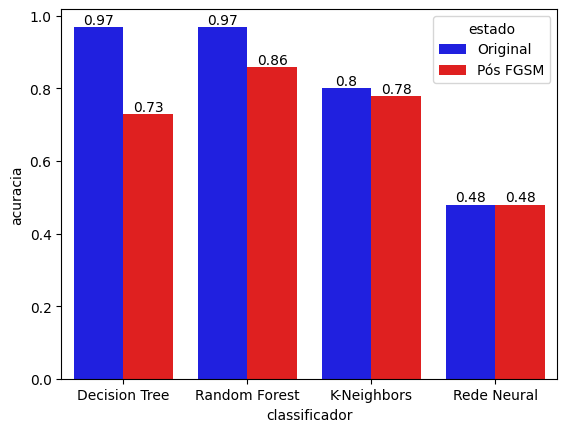

In [12]:
color_array = ['blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red']

ax = sns.barplot(df_plot, x='classificador', y='acuracia', hue='estado', palette=color_array)

for i in ax.containers:
  ax.bar_label(i,)

plt.show()